In [0]:
!pip3 install pybullet --upgrade

     |████████████████████████████████| 95.3MB 55kB/s 


In [0]:
!pip install ptan

     |████████████████████████████████| 773.1MB 22kB/s 
  Created wheel for ptan: filename=ptan-0.6-cp36-none-any.whl size=23502 sha256=12817082f5e2ffa74380c2f656481239645c971013a6f4353fa4f43c7a66533f
  Stored in directory: /root/.cache/pip/wheels/f0/4b/2f/9a45fd39b0a614a2716bc6128a7f1adb4647f323a2d90783f2
Successfully built ptan
ERROR: torchvision 0.6.0+cu101 has requirement torch==1.5.0, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101


In [0]:
import pybullet_envs
import ptan
import math

In [0]:
from pybullet_envs.gym_locomotion_envs import HumanoidBulletEnv

In [0]:
env=HumanoidBulletEnv

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as op

In [0]:
from pybullet_envs.gym_locomotion_envs import HumanoidBulletEnv
env = gym.make('HumanoidBulletEnv-v0')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:

env.reset()

array([ 5.9999996e-01, -1.4897665e-05,  1.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
        7.7077754e-02,  0.0000000e+00,  3.5623616e-01,  0.0000000e+00,
        1.2326540e-01,  0.0000000e+00,  3.5845414e-01,  0.0000000e+00,
        3.2599449e-01,  0.0000000e+00,  6.6974747e-01,  0.0000000e+00,
        1.0395368e+00,  0.0000000e+00,  4.5070380e-01,  0.0000000e+00,
        2.4528269e-01,  0.0000000e+00,  6.9656032e-01,  0.0000000e+00,
        1.0202981e+00,  0.0000000e+00,  1.9063413e-01,  0.0000000e+00,
        2.5046584e-01,  0.0000000e+00,  2.5520271e-01,  0.0000000e+00,
       -2.0996340e-01,  0.0000000e+00, -2.2632049e-01,  0.0000000e+00,
        3.0909577e-01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

In [0]:
testenv=gym.make('HumanoidBulletEnv-v0')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


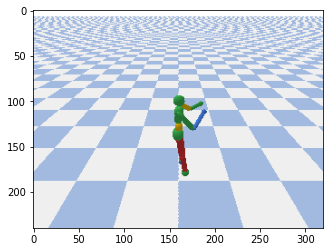

In [0]:
plt.imshow(env.render(mode="rgb_array"))     #Displaying environment image


In [0]:
# action meanings
env.action_space   # continuous action space

Box(17,)

In [0]:
#observation space  
env.observation_space

Box(44,)

In [0]:
env.action_space.low

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1.], dtype=float32)

In [0]:
env.action_space.high

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [0]:
env.observation_space.low

array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
      dtype=float32)

In [0]:
# Softplus Activation Function understanding

In [0]:
x=np.linspace(-10,10,100)
y=np.log(1+np.exp(x))

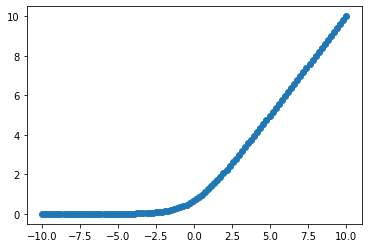

In [0]:
plt.scatter(x,y)

In [0]:
obsdim=env.observation_space.shape[0]
actdim=env.action_space.shape[0]

In [0]:
class act_critic(nn.Module):
  def __init__(self,obsdim,actdim):
    super().__init__()
    self.fc1=nn.Linear(obsdim,64)
    self.fc2=nn.Linear(64,32)
    self.fc3=nn.Linear(32,16)
    self.fc4=nn.Linear(16,actdim)    # mean of action dimensions
    self.fc5=nn.Linear(16,actdim)    # std of action dimensions
    self.fc6=nn.Linear(16,1)         # Value of state

  def forward(self,x):
    out=f.leaky_relu(self.fc1(x))
    out=f.leaky_relu(self.fc2(out))
    out1=f.leaky_relu(self.fc3(out))
    mean=f.tanh(self.fc4(out1))
    variance= f.softplus(self.fc5(out1))
    vs= self.fc6(out1)
    return mean,variance,vs

In [0]:
model=act_critic(obsdim,actdim)

In [0]:
np.random.normal(loc=[1,1,1,1],scale=[0.1,0.2,0.3,0.4])  # used to randomly sample values given mean and std deviation

array([1.10045702, 1.24829608, 1.3218433 , 0.79525583])

In [0]:
class agent(ptan.agent.BaseAgent):
  def __init__(self,net,device='cpu'):
    self.net=net
    self.device=device
  
  def __call__(self,states,agent_states):
    statesv=ptan.agent.float32_preprocessor(states)
    statesv=statesv.to(device)
    mu,var,_=self.net(statesv)
    mu=mu.data.cpu().numpy()
    std=torch.sqrt(var).data.cpu().numpy()
    actions=np.random.normal(mu,std)
    actions=np.clip(actions,-1,1)
    return actions,agent_states

In [0]:
def testnet(net,env,count=10,device="cpu"):
  rewards=0
  steps=0
  for _ in range(count):
    obs=env.reset()
    while True:
      obsv=ptan.agent.float32_preprocessor([obs])
      obsv=obsv.to(device)
      mu_v=net(obsv)[0]
      action=mu_v.squeeze(0).data.cpu().numpy()
      obs,reward,done,_=env.step(action)
      rewards+=reward
      steps+=1
      if done:
        break
  return rewards/count , steps/count
  

In [0]:
def calc_logprob(mu_v,var_v,actions_v):   # log(prob)
  p1=-((mu_v-actions_v)**2)/(2*var_v.clamp(min=1e-3))   # this is very important
  p2=-(torch.log(torch.sqrt(2*(math.pi)*var_v)))
  return p1+p2

In [0]:
gamma=0.99
steps=2
batchsize=32
lr=5e-5
entr_beta=1e-4
test_iter=1000
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
agent1=agent(model,device)

In [0]:
expsource=ptan.experience.ExperienceSourceFirstLast(env,agent1,gamma,steps_count=steps)

In [0]:
# important understanding 
# variance is always positive and its range is between 0 to infi so we used softplus
# mean value should lie inbetween -1,1 for actions thats why we used tanh
# expsource.pop_rewards_steps() gives two values as list [ totalreward,number of steps] for an episode

In [0]:
count=0
for i in expsource:
  count+=1
  if i.last_state is None:
    print(i.state)
    print(i.reward)
    print(i.action)
    print(i.last_state)
    print(count)
    print(expsource.pop_rewards_steps())
    break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[ 0.05246561  0.08608261  0.996288   -0.05586585 -0.00783027 -0.84022784
  0.01323351  0.37175784  0.87107956 -0.45853463 -0.35322008 -0.49459144
 -0.450326   -0.5811196   0.13453244 -0.02543593  0.01978886 -0.08429621
  1.0083607  -0.06190684 -0.8278752  -0.106431    0.28159598 -0.16326708
  0.23014475 -0.29788646 -0.65956765  0.532713   -0.90468603 -0.22697383
 -0.024572   -0.14321822  0.41876623 -0.33978635  0.9169971   3.3941648
 -0.00770415 -0.23888414 -0.13098131 -0.525719    0.22950815 -2.7397683
  0.          0.        ]
-4.695993861726402
[ 1.         -1.         -0.69167389  0.83177696  0.1897779   0.1255252
 -0.77885334  0.48579639 -0.2375151   0.32253937  0.53610623 -0.56197611
 -0.1930312  -0.65394843  0.54050745 -0.67672887 -0.3094153 ]
None
18
[]


In [0]:
a=np.array([True,False,True])   # very important numpy operation 

In [0]:
print(a.all())    # all checks if all elements are True
print(a.any())    # any checks if any of element is True

False
True


In [0]:
def unpack_batcha2c(batch,net,lastvalgamma,device=device):     # getting S,a r,S'
  states=[]
  actions=[]
  rewards=[]
  notdoneidx=[]
  laststates=[]
  doneidx=[]
  for idx,exp in enumerate(batch):
    states.append(exp.state)
    actions.append(exp.action)
    rewards.append(exp.reward)

    if exp.last_state is not None:
      notdoneidx.append(idx)
      laststates.append(exp.last_state)
    else:
      doneidx.append(idx)

  rewardsnp=np.array(rewards,dtype=np.float32).reshape(-1,1)
  statesv=ptan.agent.float32_preprocessor(states).to(device)
  actionsv=torch.FloatTensor(actions).to(device)

  if notdoneidx:
    laststatesv=ptan.agent.float32_preprocessor(laststates).to(device)
    laststatesval=net(laststatesv)[2]
    laststatesvalnp=laststatesval.data.cpu().numpy()
    rewardsnp[notdoneidx]+=lastvalgamma*laststatesvalnp  # Q(s,a)=cr+gamma(Vs)
  
  refval=torch.FloatTensor(rewardsnp).to(device) # calculated using bellman equation
  return statesv,actionsv,refval

In [0]:
optimizer=op.Adam(model.parameters(),lr=0.0001)

In [0]:
step=2
tloss=[]

In [0]:
eloss=[]
vloss=[]

In [0]:
batch=[]
bestreward=None
count=0
for idx,exp in enumerate(expsource):
  rewardssteps=expsource.pop_rewards_steps()
  if rewardssteps:
    rewards,steps=zip(*rewardssteps)
  batch.append(exp)
  if len(batch)< batchsize:
    continue
  count+=1
  states,actions,refvals=unpack_batcha2c(batch,model,lastvalgamma=gamma**step,device=device)
  batch.clear()

  optimizer.zero_grad()
  muv,varv,valv=model.forward(states)  # valv is value of current state
  lossvaluev=f.mse_loss(valv,refvals)    # we assume that currentreward+gamma*V(nextstate)=V(currentstate)
  logprobv=calc_logprob(muv,varv,actions)
  advantagev=(refvals-valv.detach()) # we dont want gradients to propagate through advantage values thats why we used valv.detach()
  logprobloss=-1*(advantagev)*logprobv
  logprobloss=logprobloss.mean()
  entropy=(-(torch.log(2*(math.pi)*varv)/2).mean())*entr_beta
  totalloss=entropy+logprobloss+lossvaluev

  totalloss.backward()
  optimizer.step()
  vloss.append(lossvaluev.item())
  eloss.append(entropy.item())
  tloss.append(totalloss.item())
  if count>20000:
    break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


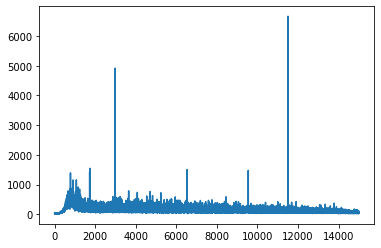

In [0]:
plt.plot(tloss[:15000])

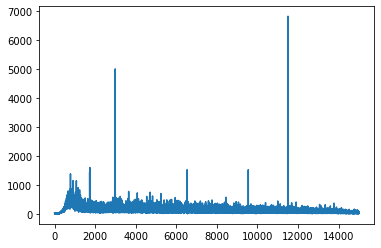

In [0]:
plt.plot(vloss[:15000])

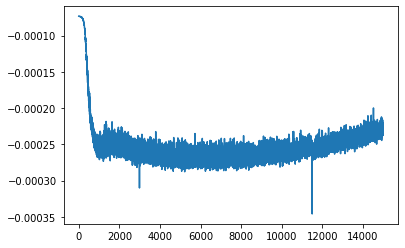

In [0]:
plt.plot(eloss[:15000])


In [0]:
testenv=gym.wrappers.Monitor(env,"/content/")

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [0]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [0]:
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
env = wrap_env(gym.make('HumanoidBulletEnv-v0'))

In [0]:
obs=env.reset()
while True:
  env.render()
  obs=ptan.agent.float32_preprocessor(obs)
  action=model.forward(obs)[0].data.cpu().numpy()
  obs,rew,done,_=env.step(action)
  if done:
    break

env.close()
show_video()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
